# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os

from itertools import product
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm
import talib

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
sns.set_style('whitegrid')

In [5]:
YEAR = 252
idx = pd.IndexSlice

In [6]:
DATA_DIR = Path('..', 'data')

In [7]:
figure_path = Path('figures')
model_path = Path('models')
for path in [figure_path, model_path]:
    if not path.exists():
        path.mkdir()

## Get Data

See the notebook [japanese_equity_features](03_japanese_equity_features.ipynb) in this directory for data preparation.

In [8]:
data = pd.read_hdf('data.h5', 'stooq/japan/equities')
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2303568 non-null  float64
 1   ret_rel_perc_1   2303568 non-null  float64
 2   ret_5            2299804 non-null  float64
 3   ret_rel_perc_5   2299804 non-null  float64
 4   ret_10           2295099 non-null  float64
 5   ret_rel_perc_10  2295099 non-null  float64
 6   ret_21           2284748 non-null  float64
 7   ret_rel_perc_21  2284748 non-null  float64
 8   ret_63           2245226 non-null  float64
 9   ret_rel_perc_63  2245226 non-null  float64
 10  PPO              2280984 non-null  float64
 11  NATR             2291335 non-null  float64
 12  RSI              2291335 non-null  float64
 13  bbl              2300745 non-null  float64
 14  bbu              2300745 non-nul

We start with 941 tickers.

In [9]:
len(data.index.unique('ticker'))

941

### Select universe of 250 most-liquid stocks

In [10]:
prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices')
          .loc[idx[:, '2010': '2017'], :])

dollar_vol = prices.close.mul(prices.volume).loc[idx[:, :'2017'],:]
dollar_vol_rank = dollar_vol.groupby(level='date').rank(ascending=False)
universe = dollar_vol_rank.groupby(level='ticker').mean().nsmallest(250).index

## MultipleTimeSeriesCV

See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [11]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

In [12]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='ticker').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='ticker').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    if i == 3:
        break

508 2017-10-24 2019-11-25 21 2019-12-02 2019-12-30
508 2017-09-22 2019-10-24 21 2019-10-31 2019-11-29
508 2017-08-23 2019-09-20 21 2019-09-30 2019-10-30
508 2017-07-24 2019-08-21 21 2019-08-28 2019-09-27


## Model Selection: Time Period and Horizon

In [13]:
cv_data = data.loc[idx[universe, :'2017'], :]
tickers = cv_data.index.unique('ticker')

In [15]:
cv_data.to_hdf('data.h5', 'stooq/japan/equities/cv_data')

In [16]:
with pd.HDFStore('data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/stooq/japan/equities                    frame        (shape->[2304509,23])
/stooq/japan/equities/cv_data            frame        (shape->[418119,23]) 
/us/equities/monthly                     frame        (shape->[56756,27])  
/us/equities/prices                      frame        (shape->[9532628,16])


In [13]:
lookaheads = [1, 5, 10, 21]

## Baseline: Linear Regression

In [14]:
lr = LinearRegression()

In [20]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [21]:
train_lengths = [5*YEAR, 3*YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

In [22]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [23]:
lr_metrics = []
for lookahead, train_length, test_length in test_params:
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

In [24]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB


### Information Coefficient distribution by Lookahead

In [25]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     80 non-null     int64  
 1   Train Length  80 non-null     int64  
 2   Test Length   80 non-null     int64  
 3   IC            80 non-null     float64
 4   Measure       80 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB


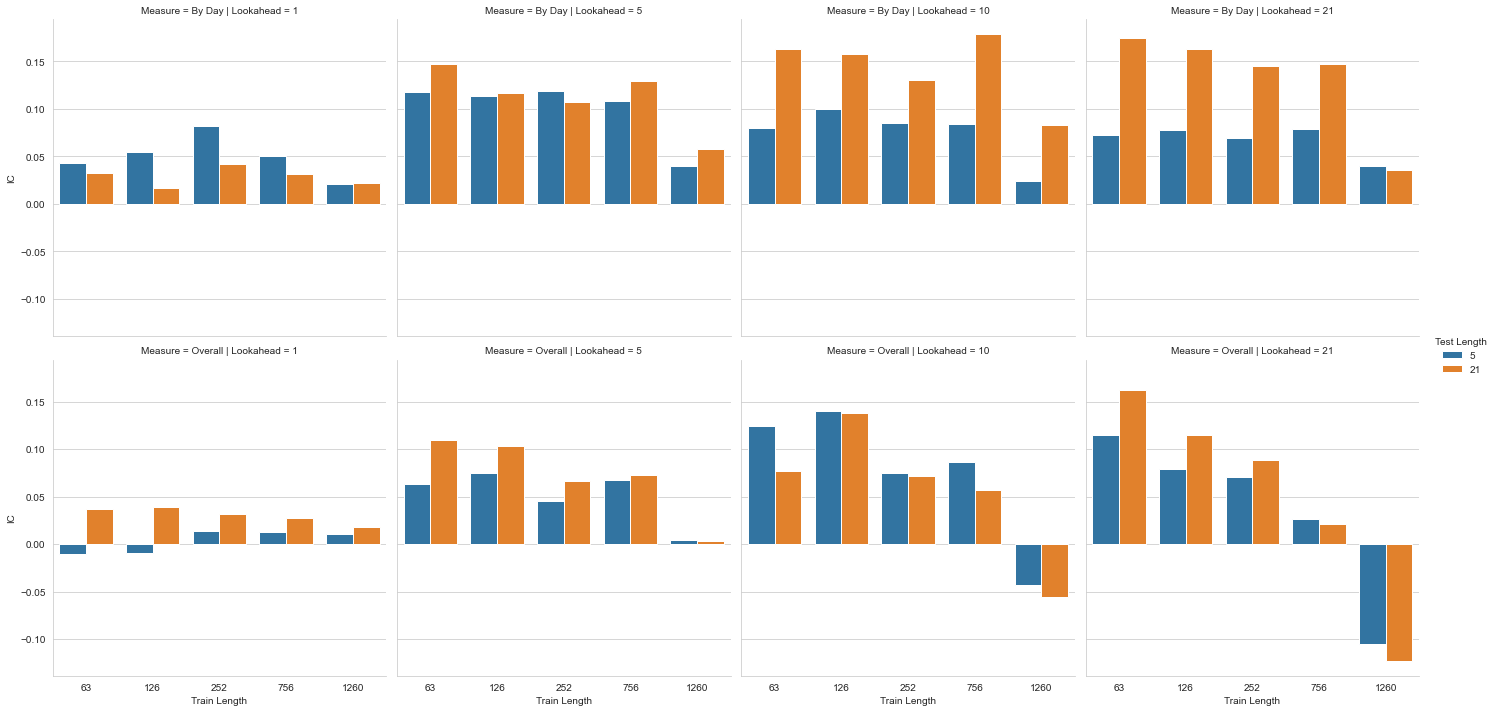

In [28]:
sns.catplot(x='Train Length', 
            y='IC', 
            hue='Test Length', 
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar');

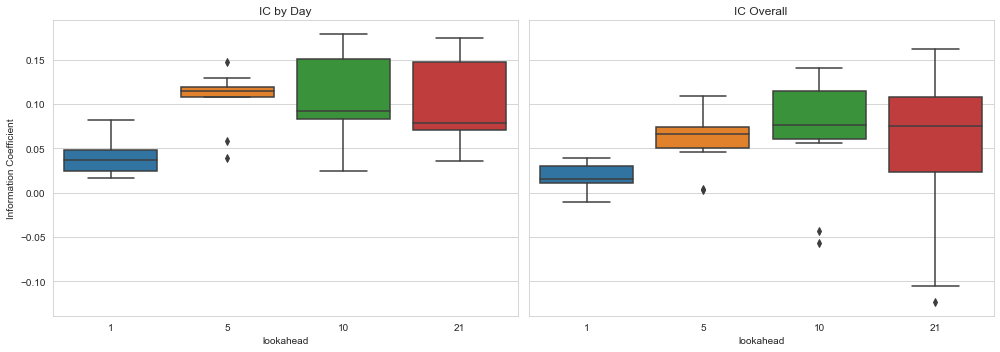

In [29]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### Best Train/Test Period Lengths

In [30]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
7,1,126,21,0.016434,0.038789
9,1,63,21,0.032385,0.037069
5,1,252,21,0.041827,0.031695
19,5,63,21,0.146818,0.109303
17,5,126,21,0.116249,0.102857
16,5,126,5,0.113445,0.074862
26,10,126,5,0.099613,0.140385
27,10,126,21,0.158008,0.138160
28,10,63,5,0.080163,0.123941
39,21,63,21,0.174693,0.161913


In [31]:
lr_metrics.to_csv(model_path / 'lin_reg_performance.csv', index=False)

## LightGBM Random Forest Model Tuning

In [32]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

In [33]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

In [34]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [250, 500, 1000]

In [35]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

#### Random Sample

In [36]:
sample_proportion = 1.0
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(sample_size)), 
                                     size=int(n_cv_params), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 18


In [37]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

### Train/Test Period Lenghts

#### Define parameters

In [39]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

In [40]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

#### Random sample

In [41]:
sample_proportion = 1.0
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(sample_size)), 
                                     size=int(n_test_params), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 10
CV Iterations: 180


### Categorical Variables

In [42]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Run Cross-Validation

In [43]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [45]:
label_dict = dict(zip(lookaheads, labels))

In [46]:
cv_store = Path(f'parameter_tuning.h5')

In [47]:
ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

In [49]:
for t in lookaheads:
    for train_length, test_length in test_params_:
        n_splits = int(2 * YEAR / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        outcome_data = data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               categorical_feature=categoricals,
                               free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                lgb_test = lgb_data.subset(test_idx.tolist()).construct()

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                    x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)

        m = pd.DataFrame(ic, columns=ic_cols)
        m.to_hdf(store, 'ic/' + key)
        pd.concat(daily_ic).to_hdf(cv_store, 'daily_ic/' + key)
        pd.concat(feature_importance).to_hdf(cv_store, 'fi/' + key)
        pd.concat(predictions).to_hdf(cv_store, 'predictions/' + key)

Lookahead:  1 | Train:  63 | Test: 21 | Params:  18


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


  0 | 00:01:01 | 50% | 75% |   250 |  1.98% |  1.08% |  1.02%
  1 | 00:02:06 | 50% | 75% |   500 |  1.92% |  1.34% |  1.43%
  2 | 00:03:09 | 75% | 75% | 1,000 |  2.03% |  1.32% |  1.30%
  3 | 00:04:03 | 50% | 95% | 1,000 |  2.27% |  1.12% |  1.16%
  4 | 00:05:03 | 50% | 95% |   250 |  2.62% |  1.04% |  0.87%
  5 | 00:06:07 | 95% | 75% |   500 |  2.08% |  0.96% |  0.89%
  6 | 00:07:13 | 95% | 95% |   500 |  2.76% |  0.95% |  0.67%
  7 | 00:08:17 | 95% | 95% |   250 |  2.25% |  0.69% |  0.32%
  8 | 00:09:19 | 75% | 95% | 1,000 |  2.51% |  1.04% |  0.71%
  9 | 00:10:14 | 50% | 75% | 1,000 |  1.87% |  1.18% |  1.30%
 10 | 00:11:15 | 75% | 95% |   250 |  2.10% |  0.73% |  0.34%
 11 | 00:12:19 | 95% | 95% | 1,000 |  2.29% |  1.09% |  1.21%
 12 | 00:13:19 | 50% | 95% |   500 |  2.44% |  1.25% |  1.21%
 13 | 00:14:22 | 95% | 75% |   250 |  1.68% |  0.85% |  0.93%
 14 | 00:15:25 | 75% | 75% |   500 |  1.61% |  0.99% |  1.03%
 15 | 00:16:27 | 75% | 95% |   500 |  2.13% |  0.75% |  0.34%
 16 | 00

NameError: name 'store' is not defined

## Analyse Cross-Validation Results

### Collect Data

In [43]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

In [ ]:
for t in lookaheads:
    daily, ic, predictions = [], [], []
    with pd.HDFStore(f'parameter_tuning_{t:02}.h5') as store:
        keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            k = f'{t}/{train_length}/{test_length}'
            cols = {'t': t,
                    'train_length': int(train_length),
                    'test_length': int(test_length)}

            ic.append(pd.melt(store['metrics/' + k]
                              .assign(**cols),
                              id_vars=id_vars[:-1],
                              value_name='ic',
                              var_name='rounds')
                      .apply(pd.to_numeric))

            df = store['daily_ic/' + k].assign(**cols).reset_index()
            daily.append(pd.melt(df,
                                 id_vars=id_vars,
                                 value_name='daily_ic',
                                 var_name='rounds')
                         .set_index('date')
                         .apply(pd.to_numeric)
                         .reset_index())
            predictions.append(store['predictions/' + k].assign(**cols))
    predictions = pd.concat(predictions)
    ic = pd.concat(ic, ignore_index=True)
    daily = pd.concat(daily, ignore_index=True)
    with pd.HDFStore('parameter_tuning2.h5') as target:
        #         target.put(f'predictions/{t:02}', predictions)
        target.put(f'daily/{t:02}', daily_ic)
        target.put(f'ic/{t:02}', metrics)

In [ ]:
T = [1, 5, 10, 21]
with pd.HDFStore('parameter_tuning.h5') as store:
    ic = pd.concat([store[f'daily_ic/{t:02}'] for t in T], ignore_index=True)
    store.put('ic', ic)
    daily = pd.concat([store[f'metrics/{t:02}'] for t in T], ignore_index=True)
    store.put('daily_ic', daily)

In [112]:
with pd.HDFStore('parameter_tuning.h5') as store:
    ic = store['ic']
    daily_ic = store['daily_ic']

### Predictive Performance: CV Information Coefficient by Day

In [114]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
2369,1,756,21,0.95,0.75,1000,50,0.015482
1955,1,756,21,0.50,0.95,1000,200,0.014808
3838,1,1260,21,0.95,0.95,250,275,0.014794
6500,5,756,21,0.50,0.75,1000,125,0.029656
6501,5,756,21,0.50,0.75,1000,150,0.029217
6498,5,756,21,0.50,0.75,1000,75,0.029204
12305,10,756,63,0.95,0.75,1000,50,0.035574
12306,10,756,63,0.95,0.75,1000,75,0.035109
12304,10,756,63,0.95,0.75,1000,25,0.033776
16272,21,756,63,0.50,0.25,250,25,0.054338


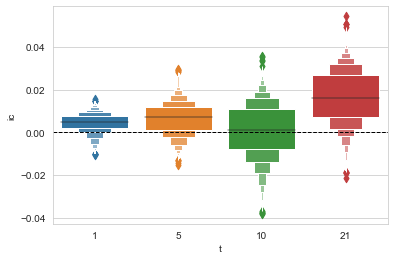

In [115]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

In [148]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18432 entries, 0 to 18431
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 18432 non-null  int64  
 1   train_length      18432 non-null  int64  
 2   test_length       18432 non-null  int64  
 3   bagging_fraction  18432 non-null  float64
 4   feature_fraction  18432 non-null  float64
 5   min_data_in_leaf  18432 non-null  int64  
 6   rounds            18432 non-null  int64  
 7   ic                18432 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 1.1 MB


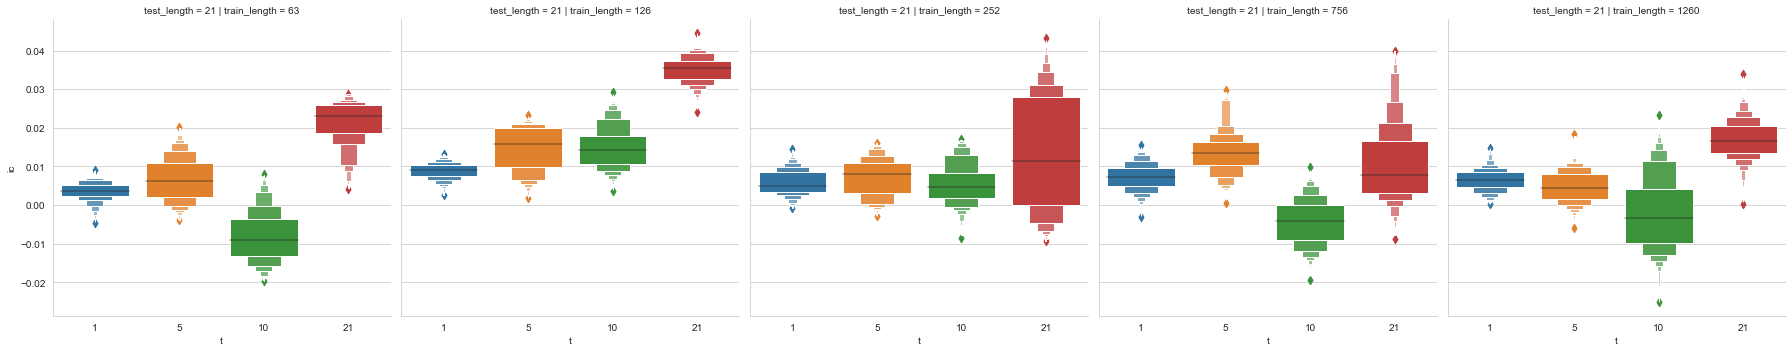

In [157]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == 21)],
                kind='boxen')
g.savefig('figures/daily_ic_test_21', dpi=300);

### HyperParameter Impact: Linear Regression

In [247]:
lin_reg = {}
for t in [1, 5]:
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err',
                     't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(model_path / f'lr_result_{t:02}.csv', index=False)

In [248]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith(
        'date') & (coefs.variable != 'const')]
    coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, 
               color='none', capsize=3, yerr='error', legend=False, rot=0)    
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

    ax.annotate('Train\nLength', xy=(.09, -0.1), xytext=(.09, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Test\nLength', xy=(.23, -0.1), xytext=(.23, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Bagging\nFraction', xy=(.32, -0.1), xytext=(.32, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.7, lengthB=0.8', lw=1.0, color='black'))


    ax.annotate('Feature\nFraction', xy=(.44, -0.1), xytext=(.44, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=3.4, lengthB=1.0', lw=1.0, color='black'))
    

    ax.annotate('Min.\nSamples', xy=(.55, -0.1), xytext=(.55, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.0', lw=1.0, color='black'))    
    
    ax.annotate('Number of\nRounds', xy=(.8, -0.1), xytext=(.8, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=1.0', lw=1.0, color='black'))

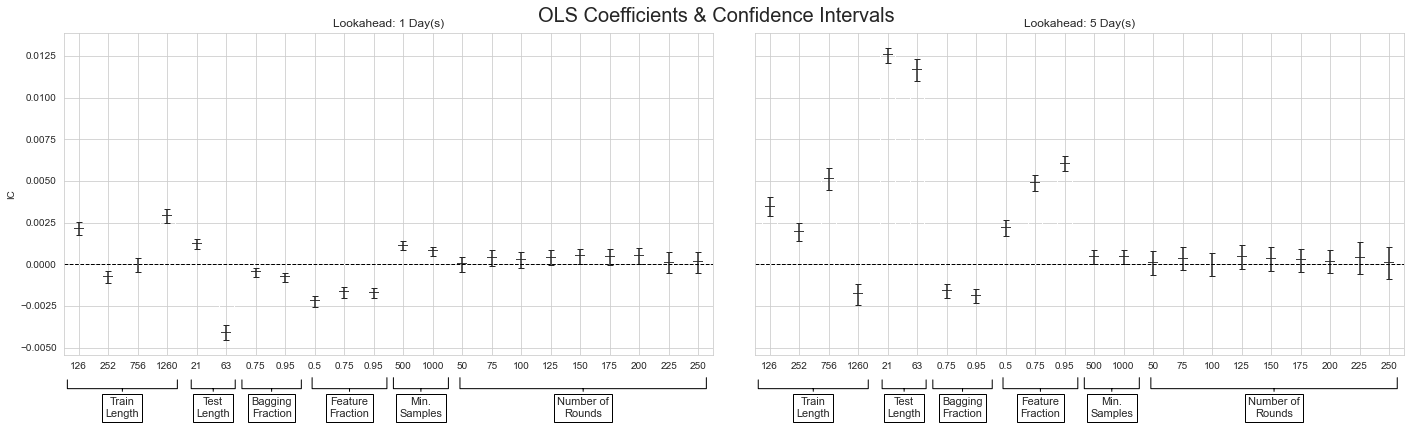

In [249]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), sharey=True)
axes = axes.flatten()
for i, t in enumerate([1, 5]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92)
# fig.savefig('figures/ols_coefs', dpi=300);

### Information Coefficient: Overall

In [122]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      18720 non-null  int64  
 1   test_length       18720 non-null  int64  
 2   bagging_fraction  18720 non-null  float64
 3   feature_fraction  18720 non-null  float64
 4   min_data_in_leaf  18720 non-null  int64  
 5   t                 18720 non-null  int64  
 6   rounds            18720 non-null  int64  
 7   ic                18720 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 1.3 MB


#### Best Parameters

In [123]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                        
1  4              756           21              0.50              0.50   
   31             756           21              0.50              0.50   
   631            756           21              0.50              0.95   
5  1             1260           63              0.50              0.50   
   5             1260           63              0.75              0.50   
   31            1260           63              0.75              0.50   
10 125            756           63              0.95              0.95   
   269            756           63              0.95              0.95   
   305            756           63              0.95              0.95   
21 456             63           21              0.75              0.75   
   672             63           21              0.75              0.75   
   1320            63           21              0.75              0.75   

         min_data_in_leaf   t  rounds        ic  
t                                                
1  4                  500   1      25  0.034207  
   31                 250   1      25  0.033630  
   631               1000   1     450  0.033300  
5  1                  500   5      25  0.108238  
   5                  500   5      25  0.104870  
   31                 250   5      25  0.104699  
10 125                250  10     100  0.110669  
   269                250  10     200  0.110430  
   305                250  10     225  0.110393  
21 456               1000  21      75  0.168191  
   672               1000  21     100  0.167338  
   1320              1000  21     175  0.166442

#### Visualiztion

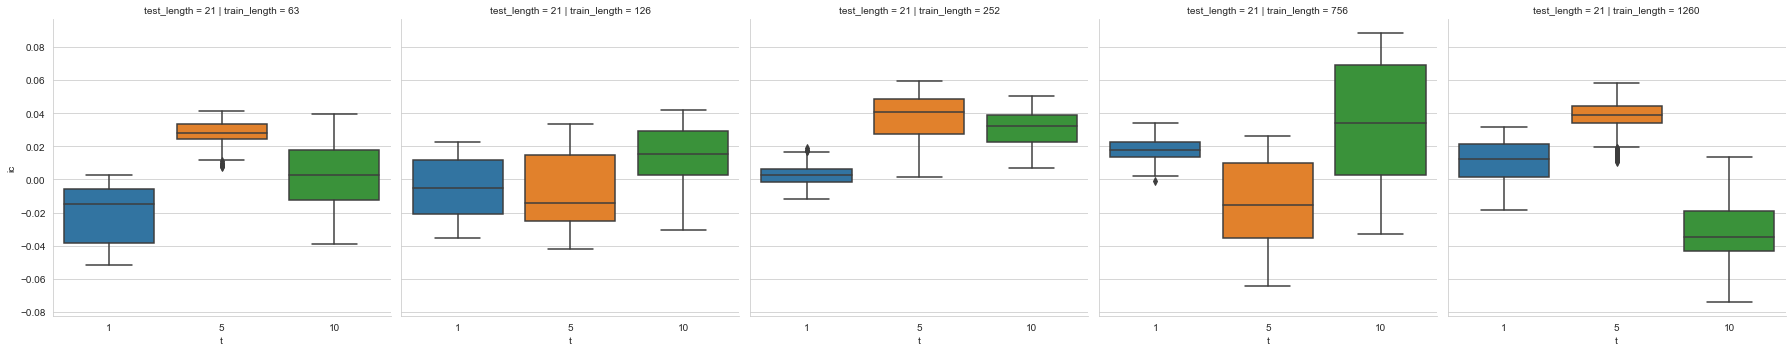

In [144]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 21) & (ic.t < 21)],
                kind='box')
g.savefig('figures/ic_test_21', dpi=300)

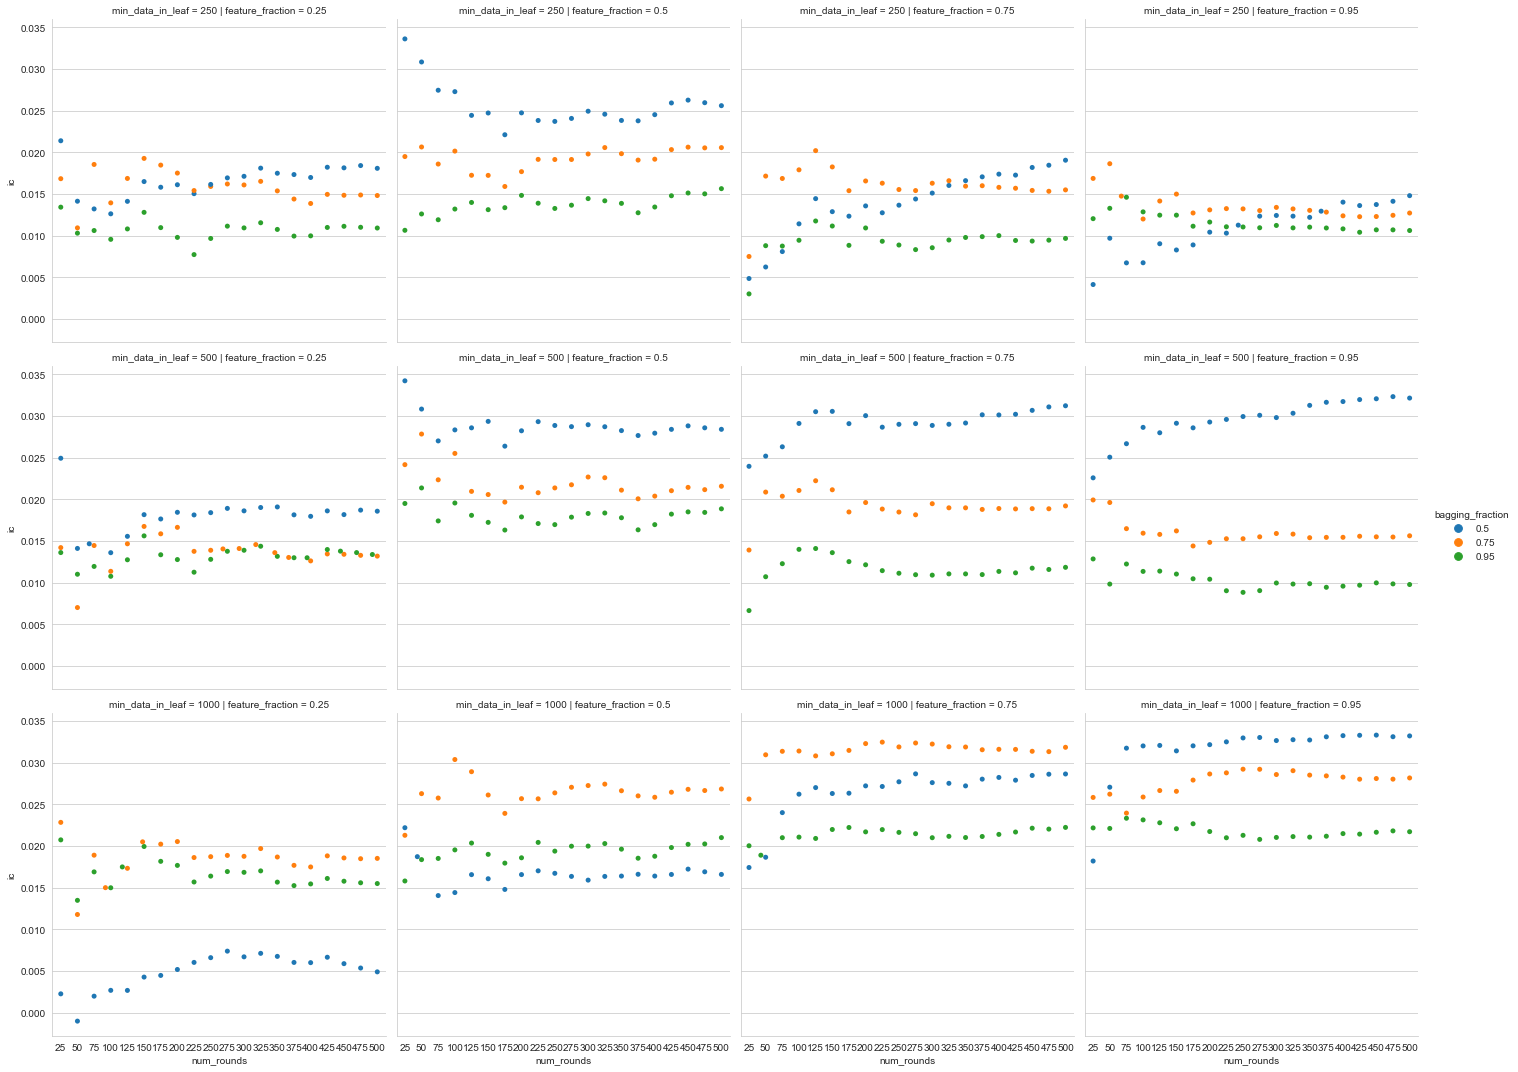

In [90]:
t = 1
train_length = 756
test_length = 21
g = sns.catplot(
    x='num_rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=ic[(ic.t == t) &
            (ic.train_length == train_length) &
            (ic.test_length == test_length)],
    kind='swarm')
# g.savefig('figures/catplot_05b', dpi=300);

### Random Forest vs Linear Regression 

In [127]:
lr_metrics = pd.read_csv(model_path / 'lr_metrics.csv')
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     24 non-null     int64  
 1   train_length  24 non-null     int64  
 2   test_length   24 non-null     int64  
 3   ic_by_day     24 non-null     float64
 4   ic            24 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.1 KB


In [130]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18432 entries, 0 to 18431
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 18432 non-null  int64  
 1   train_length      18432 non-null  int64  
 2   test_length       18432 non-null  int64  
 3   bagging_fraction  18432 non-null  float64
 4   feature_fraction  18432 non-null  float64
 5   min_data_in_leaf  18432 non-null  int64  
 6   rounds            18432 non-null  int64  
 7   ic                18432 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 1.1 MB


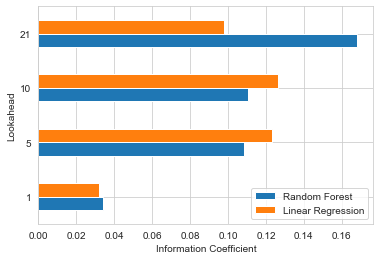

In [132]:
ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
 .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
ax.set_ylabel('Lookahead')
ax.set_xlabel('Information Coefficient')
plt.savefig('figures/lr_vs_rf', dpi=300);

## Generate predictions

In [137]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

In [138]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

In [139]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

store = Path('predictions.h5')

In [140]:
for lookahead in [1, 5, 10, 21]:
    if lookahead > 1: continue
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_hdf('data.h5', 'stooq/japan/equities'))
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(10):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = int(2 * YEAR / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            lgb_train = lgb_data.subset(train_idx.tolist()).construct()

            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)

            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        

    by_day = test_predictions.groupby(level='date')
    for position in range(10):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])

    test_predictions.to_hdf(store, f'test/{lookahead:02}')


Lookahead: 01
	Position: 00
	Position: 01
	Position: 02
	Position: 03
	Position: 04
	Position: 05
	Position: 06
	Position: 07
	Position: 08
	Position: 09
